# Explainabability on Lenet

In [1]:
from torchvision import datasets, transforms
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset
import matplotlib.pyplot as plt

# Using smaller version of mnist

In [2]:
train_data=pd.read_csv('mnist_train_small.csv').iloc[:][1:]
x_train=torch.tensor(np.array(train_data.iloc[:,1:]))
y_train= torch.tensor(np.array(train_data.iloc[:,0]))

test_data=pd.read_csv('mnist_test.csv').iloc[:][1:]
x_test=torch.tensor(np.array(test_data.iloc[:,1:]))
y_test= torch.tensor(np.array(test_data.iloc[:,0]))

# Use trained LEnet model

In [3]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5x5 image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, int(x.nelement() / x.shape[0]))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [4]:
model=LeNet()
model=torch.load('Lenet_model_1')
model.eval()

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [5]:
test_data.shape

(9998, 785)

## Evaluate the model

In [6]:
pred=model(x_test.reshape(-1,1,28,28).float())
y_pred=torch.max(pred.data,1)[1]

accuracy=sum(np.array(y_pred==y_test, int))/len(y_test)
print('Accuracy on test: ', accuracy*100, '%')

Accuracy on test:  97.06941388277656 %


# Explanation

### the explanation is based on Shap values, based on the paper https://arxiv.org/abs/1705.07874

In [7]:
import shap

In [20]:
# a background to calculate EM, as summnig al over is intractable
background = x_train[np.random.choice(x_train.shape[0], 100, replace=False)].reshape(-1,1,28,28)
background=torch.tensor(background).float()
background.shape

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


torch.Size([100, 1, 28, 28])

In [10]:
e = shap.DeepExplainer(model, background)

In [21]:
### Samples to explain
sample_images=x_test[:5].reshape(-1,1,28,28)
sample_images.shape

torch.Size([5, 1, 28, 28])

In [19]:
# labels for the samoples
labels=y_test[:5]

In [13]:
explanations=e.shap_values(sample_images)

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [17]:
## normally, the shap returns explanations for each class, so this simple function returns the labeled explanation
explanation = lambda image, label:e.shap_values(image)[label][0][0]

In [15]:
explanations=[explanation(sample_images[i].reshape(-1,1,28,28), labels[i]) for i in range(5)]
all_images=list(sample_images[:,0,:,:])+explanations

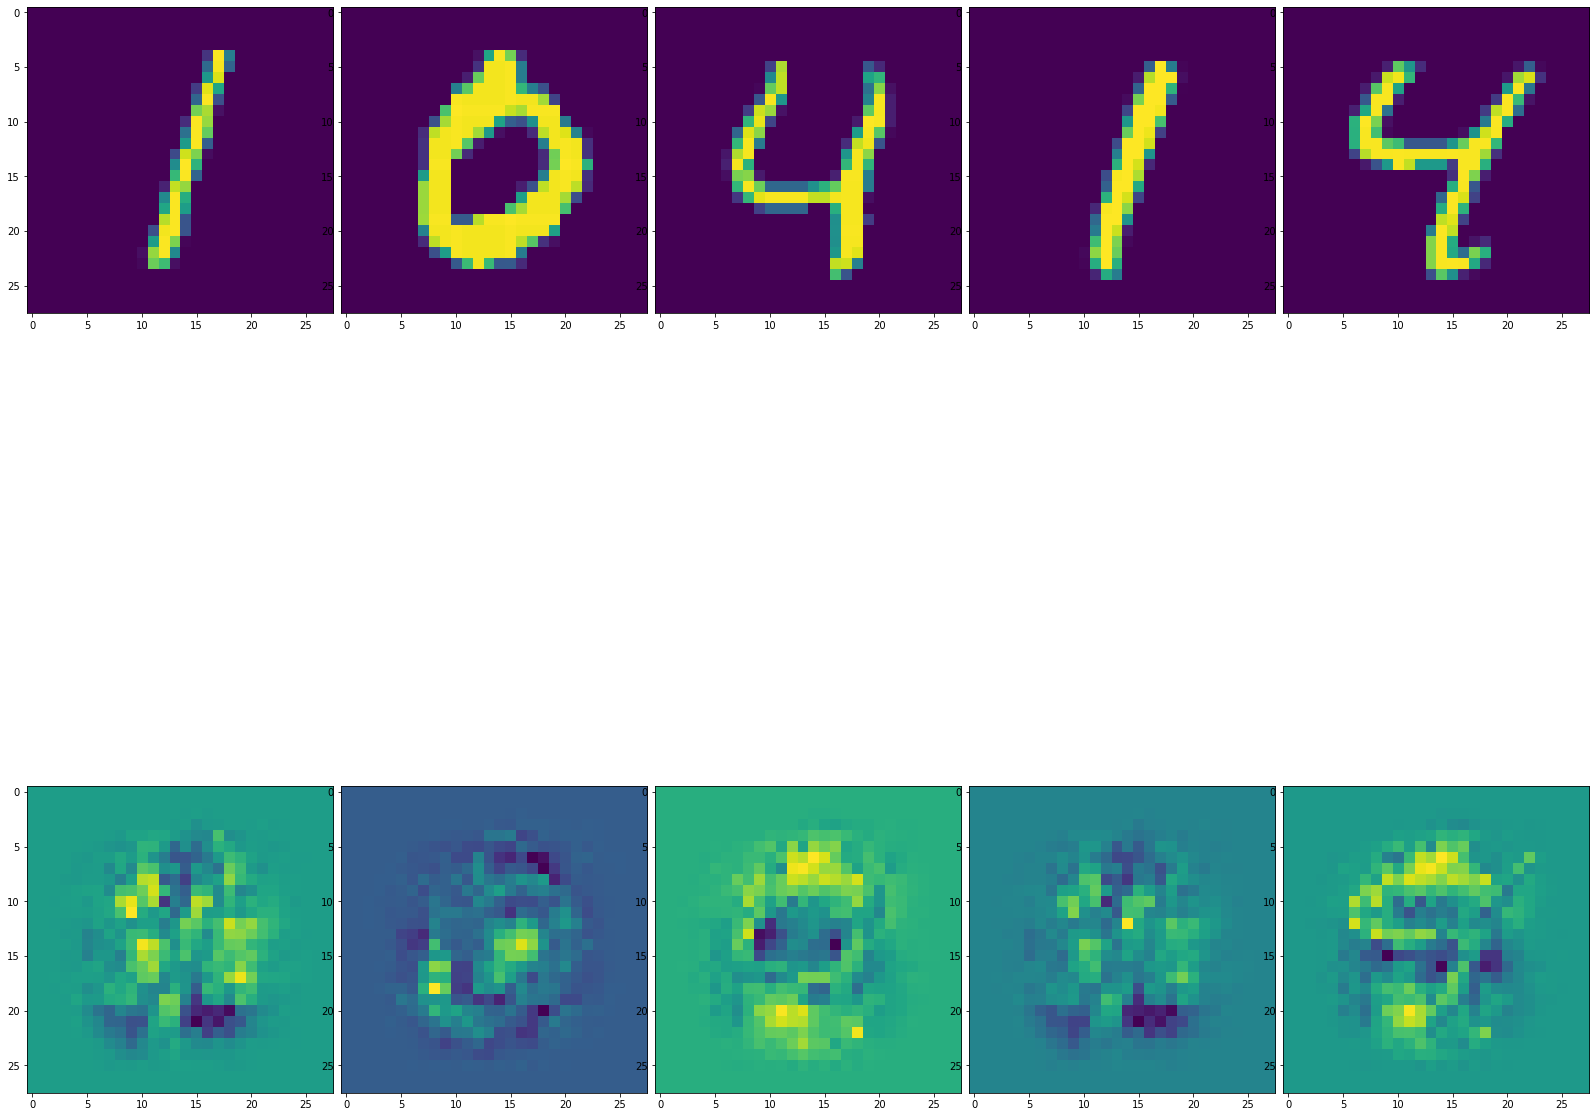

In [16]:
fig = plt.figure(figsize=(28,28))
fig.subplots_adjust(wspace=0.025, hspace=0.05) 
columns = 5
rows = 2
for i in range(1, columns*rows +1):    
    fig.add_subplot(rows, columns, i)
    plt.imshow(all_images[i-1])
    
plt.show()
